In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost
import shap
shap.initjs() # Don't worry if this doesn't work for you. Comment it out and carry on

In [2]:
if int(tf.__version__[2]) > 3:
    print("Tensorflow version above 2.3.1 has an (as of now) unsolved bug which affects the graph part of SHAP.")
    print("Please downgrade if you have 2.4.0")
    print("See also https://github.com/onnx/keras-onnx/issues/651")
    print("If you don't want to downgrade, you can run everything up to the MNIST part")

In [28]:
# Get data
boston = load_boston()

boston_dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_dataset["MEDV"] =  boston.target

# Use only a subset of features for computation time and brain power (Rooms, age, tax and crime rate)
features_to_use = ["RM", "AGE", "TAX", "CRIM", "PTRATIO"]
x_data = boston_dataset[features_to_use]
y_data = boston_dataset.MEDV

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

## XGBoost

In [29]:
# Instantiate and fit XGBoost model
regressor = xgboost.XGBRegressor()
regressor.fit(x_train, y_train);

# Make prediction
y_pred_xgb = regressor.predict(x_test)

In [30]:
# Explain XGBoost model 
explainer = shap.TreeExplainer(regressor, data=np.array(x_train))
# Calculate SHAP values
shap_values = explainer.shap_values(x_test)

In [32]:
# Pick an instance to look closer at
y_pred = regressor.predict(x_test)

print("Mean price: ", np.mean(y_test))
print("Mean price prediction: ", np.mean(y_pred))
print("Mean crime rate: ", np.mean(x_test.CRIM))

i = 6
print(x_test.iloc[i])
print("Actual price: ", y_test.iloc[i])
print("Predicted price: ", y_pred[i])
shap.force_plot(explainer.expected_value, shap_values[i,:], x_test.iloc[i,:])

Mean price:  21.643712574850298
Mean price prediction:  21.19433
Mean crime rate:  4.1457728143712576
RM           5.91400
AGE         83.20000
TAX        304.00000
CRIM         0.31827
PTRATIO     18.40000
Name: 316, dtype: float64
Actual price:  17.8
Predicted price:  19.04583


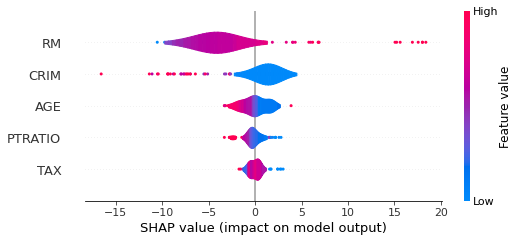

In [33]:
shap.summary_plot(shap_values, x_test, plot_type="violin")

In [34]:
# Sanity stuff

# The model is trained on y_data.shape[0] instances, which each get SHAP values
print(f"Number of instances: {len(shap_values)} (=={y_test.shape[0]})")

# The model has x_data.shape[1] input features, which each get one SHAP value
print(f"Number of SHAP values per instance: {len(shap_values[0])} (=={x_test.shape[1]})")

# SHAP values tell you how much the features drive the prediction away from the mean, which is
mean_pred_gbt = np.mean(regressor.predict(x_train)) # NOTE: On the background set for SHAP
print(f"Mean prediction over data set: {mean_pred_gbt} (approx= {explainer.expected_value})")
# Sanity check: mean model prediction and expected value according to the SHAP explainer should be the same

Number of instances: 167 (==167)
Number of SHAP values per instance: 5 (==5)
Mean prediction over data set: 22.970840454101562 (approx= 24.41828914861147)


## Neural network

In [35]:
# Should have validation data to train a neural network
x_train, x_notrain, y_train, y_notrain = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_notrain, y_notrain, test_size=0.5, random_state=42)

# Neural networks usually require preprocessing. Try different things.
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Build and fit neural network model (this architecture is a bit random. Play around with it.)
input_shape = x_test.shape[1]
output_shape = 1 # regression
epochs = 200

model = Sequential()
model.add(Dense(5, input_shape=(input_shape,), activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(output_shape, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=0.001))

model.fit(x_train, y_train, 
          batch_size=20,
          validation_data=(x_val, y_val),
          epochs=epochs, verbose=0)

# Make prediction
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(y_pred.shape[0],)

In [51]:
nn_explainer = shap.DeepExplainer(model, x_train)
shap_values = nn_explainer.shap_values(x_test)[0]

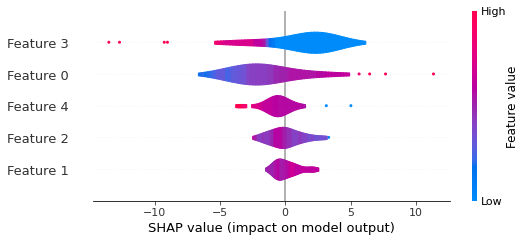

In [54]:
shap.summary_plot(shap_values, x_test, plot_type="violin")